# Computer Vision: Plant Classification

**Description:**  
This software will take as input a dataset of images of five different types of flowers (diasy, sunflower, tulip, dandelion, and rose) and use a convolutional neural network to output a classification of each image. The dataset was provided by the University of Oxford and can be accessed here — http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html. I created this program for my high school senior project where I presented my software and was awarded a Pass with Distinction.

**Specifics:**
1. Created using Python and both the Tensorflow and Keras deep learning libraries
2. Implemented convolutional layers as well as max pooling layers to detect relevant image features
3. Added both dropout and data augmentation to reduce overfitting

## Contents ::

[ **1 ) Importing Various Modules**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Modelling**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [1]:
import os
print(os.listdir('../input/flowers-recognition/flowers/flowers'))

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

['rose', 'dandelion', 'daisy', 'sunflower', 'tulip']


Using TensorFlow backend.


<a id="content2"></a>
## 2 ) Preparing the Data

Making the functions to get the training and validation set from the Images

In [2]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='../input/flowers-recognition/flowers/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../input/flowers-recognition/flowers/flowers/sunflower'
FLOWER_TULIP_DIR='../input/flowers-recognition/flowers/flowers/tulip'
FLOWER_DANDI_DIR='../input/flowers-recognition/flowers/flowers/dandelion'
FLOWER_ROSE_DIR='../input/flowers-recognition/flowers/flowers/rose'


In [3]:
def assign_label(img,flower_type):
    return flower_type
    

In [4]:
def make_train_data(flower_type,DIR):
    count = 0
    for img in tqdm(os.listdir(DIR)):
        if count > 750:
            return
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)            
        _, ftype = os.path.splitext(path)
        if ftype == ".jpg":
            img_RGB = img[...,::-1]
            img_RGB = cv2.resize(img_RGB, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img_RGB))
            Z.append(str(label))
            count+=1 

In [5]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

 96%|█████████▌| 736/769 [00:03<00:00, 232.75it/s]

751


In [6]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:03<00:00, 197.91it/s]

1485


In [7]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

 75%|███████▍  | 734/984 [00:03<00:01, 213.25it/s]

2236


In [8]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

 71%|███████   | 749/1055 [00:03<00:01, 223.32it/s]

2987


In [9]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))
print(len(Z))

 95%|█████████▍| 742/784 [00:03<00:00, 218.87it/s]

3738
3738


Visualizing some random images

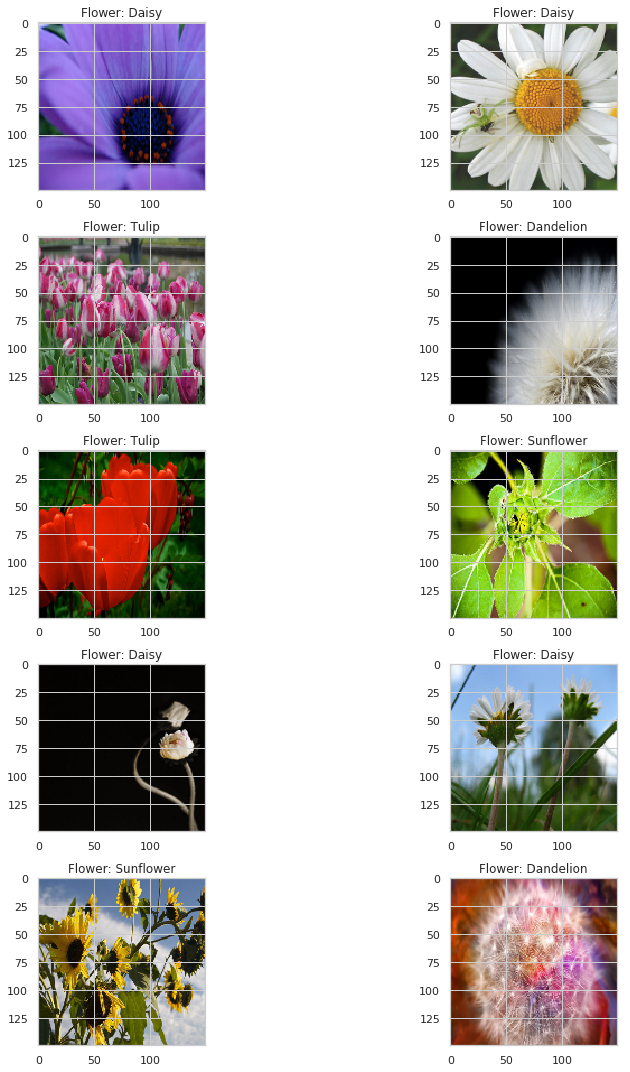

In [10]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then one hot encoding

In [11]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255
print(Y.shape)
print(X.shape)

(3738, 5)
(3738, 150, 150, 3)


Setting the random seeds

In [12]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

Splitting into training and validation sets

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

<a id="content3"></a>
## 3 ) Modelling

Building the convolutional neural network model

In [14]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis = 3))

model.add(Conv2D(filters =16, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis = 3))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis = 3))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

Data augmentation to prevent overfitting

In [15]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")
aug.fit(x_train)

Set the parameters for the neural network (i.e. the batch size and number of epochs)

In [16]:
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

batch_size=32
epochs=30

Compiling the Keras model

In [17]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 8)       608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 8)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 8)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 37, 8)         32        
__________

Fitting on the training set and making predcitons on the validation set

In [19]:
History = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // batch_size,
                              epochs=epochs)

Epoch 1/30
93/93 [==============================] - 18s 194ms/step - loss: 1.4589 - acc: 0.4422 - val_loss: 1.6020 - val_acc: 0.4332
Epoch 2/30
93/93 [==============================] - 15s 166ms/step - loss: 1.2241 - acc: 0.5131 - val_loss: 1.4131 - val_acc: 0.5227
Epoch 3/30
93/93 [==============================] - 16s 167ms/step - loss: 1.1137 - acc: 0.5700 - val_loss: 1.3597 - val_acc: 0.4880
Epoch 4/30
93/93 [==============================] - 16s 174ms/step - loss: 1.0467 - acc: 0.5842 - val_loss: 1.0818 - val_acc: 0.5909
Epoch 5/30
93/93 [==============================] - 16s 168ms/step - loss: 0.9826 - acc: 0.6057 - val_loss: 1.1355 - val_acc: 0.5722
Epoch 6/30
93/93 [==============================] - 15s 166ms/step - loss: 0.9508 - acc: 0.6275 - val_loss: 1.0217 - val_acc: 0.6150
Epoch 7/30
93/93 [==============================] - 15s 166ms/step - loss: 0.9466 - acc: 0.6271 - val_loss: 1.1915 - val_acc: 0.5334
Epoch 8/30
93/93 [==============================] - 15s 166ms/step - 

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

Plot graphs for the model's loss and accuracy

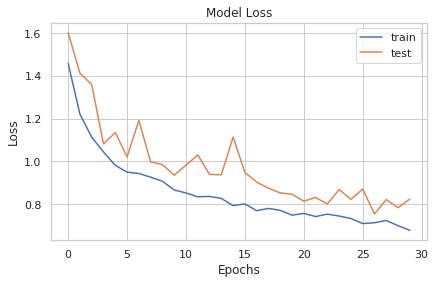

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

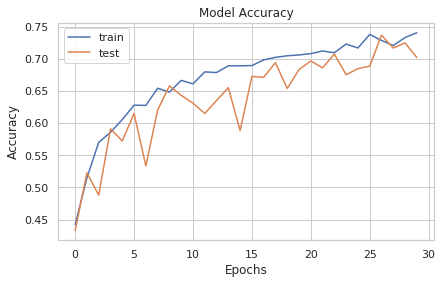

In [21]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Plot the loss and accuracy curves for training and validation 

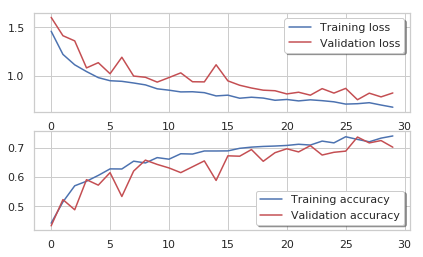

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(History.history['loss'], color='b', label="Training loss")
ax[0].plot(History.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(History.history['acc'], color='b', label="Training accuracy")
ax[1].plot(History.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)